# part0: imports

In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection


import pyaldata as pyal

if "__file__" not in dir():
    try:
        NB_Path = pathlib.Path.cwd()
        RepoPath = NB_Path.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import lstm
        import params
        monkey_defs = params.monkey_defs
        defs = monkey_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root
        reload(dt)
        reload(defs)
        reload(lstm)
        reload(params)
        
    finally:
        os.chdir(NB_Path)
    
    
    %run "S4-decode-example.ipynb"
    
    print('Done!')

Done!


---
# Part 1

functions that plot each panel.



In [ ]:
def get_ex_data():
    warnings.filterwarnings("ignore")
    raster_example = monkey_defs.raster_example
    raster_example_df = []
    for session in raster_example:
        path = root/session.split('_')[0]/session
        df = monkey_defs.prep_general(dt.load_pyal_data(path))
        # df = pyal.restrict_to_interval(df, epoch_fun=monkey_defs.exec_epoch)
        raster_example_df.append(df)
    warnings.filterwarnings("default")
    return raster_example_df

---
All in One

In [1]:
def _decode_score_and_traj(pairDF):    
    AllData, AllVel = defs.get_data_array_and_vel(pairDF, defs.exec_epoch_decode,
                                                  area=defs.areas[2], n_components=defs.n_components)
    
    # adding history
    AllData = dt.add_history_to_data_array(AllData, defs.MAX_HISTORY)
    AllData = AllData[...,defs.MAX_HISTORY:,:]
    AllVel = AllVel[...,defs.MAX_HISTORY:,:]

    AllData1 = AllData[1,...]
    AllData2 = AllData[0,...]
    AllVel1 = AllVel[1,...]
    AllVel2 = AllVel[0,...]
    # resizing
    n_target,n_trial,n_time,n_comp = AllData1.shape
    X1 = AllData1.reshape((-1,n_comp))
    X2 = AllData2.reshape((-1,n_comp))
    AllVel1 = AllVel1.reshape((-1,n_time,2))
    AllVel2 = AllVel2.reshape((-1,n_time,2))

    orig_data = AllVel2.reshape(n_target, n_trial, n_time, 2)

   
    #aligned
    *_,U,V = dt.canoncorr(X1, X2, fullReturn=True)
    U = U.reshape((-1,n_time,n_comp))
    V = V.reshape((-1,n_time,n_comp))
    lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=2)
    lstm_model.fit(x_train=U, y_train=AllVel1)
    pred, label = lstm_model.predict(V, AllVel2)
    a_scores = lstm_model.score.mean()
    a_data = (pred[:,0].reshape(n_target, n_trial, n_time),
              pred[:,1].reshape(n_target, n_trial, n_time))
   
    #unaligned
    U, V = X1, X2
    U = U.reshape((-1,n_time,n_comp))
    V = V.reshape((-1,n_time,n_comp))
    lstm_model = lstm.LSTMDecoder(input_dims=U.shape[-1], output_dims=2)
    lstm_model.fit(x_train=U, y_train=AllVel1)
    pred, label = lstm_model.predict(V, AllVel2)
    u_scores = lstm_model.score.mean()
    u_data = (pred[:,0].reshape(n_target, n_trial, n_time),
              pred[:,1].reshape(n_target, n_trial, n_time))
    
    #Within
    X1 = AllData1.reshape((-1,n_time,n_comp))

    reg_scores_ = []
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(X1[:,0,0]):
        x_train, x_test = X1[train_index,...], X1[test_index,...]
        y_train, y_test = AllVel1[train_index,...], AllVel1[test_index,...]

        lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=2)
        lstm_model.fit(x_train=x_train, y_train=y_train)
        pred, label = lstm_model.predict(x_test, y_test)
        reg_scores_.append(lstm_model.score.mean())
    w_scores = np.mean(reg_scores_)

    lstm_model = lstm.LSTMDecoder(input_dims=X1.shape[-1], output_dims=2)
    lstm_model.fit(x_train=X1, y_train=AllVel1)
    pred, label = lstm_model.predict(X1, AllVel1)
    w_data = (pred[:,0].reshape(n_target, n_trial, n_time),
              pred[:,1].reshape(n_target, n_trial, n_time))

    return n_target, n_trial, n_time, orig_data, w_data, a_data, u_data, w_scores, a_scores, u_scores

In [6]:
def plot_decoding_ex(fig, gs, trial_n = 5):

    allDFs = get_ex_data()
    *_, orig_data, w_data, a_data, u_data, w_scores, a_scores, u_scores = _decode_score_and_traj (allDFs)

    
    axes = []
    for i in range(defs.n_targets):
        axx = fig.add_subplot(gs[0,i])
        axy = fig.add_subplot(gs[1,i])
        axes.append((axx, axy))
        utility.phantom_axes(axx)
        utility.phantom_axes(axy)

        axx.plot(orig_data[i,trial_n,:,0], color='k', label='Actual')
        axy.plot(orig_data[i,trial_n,:,1], color='k', label='Actual')

        axx.plot(w_data[0][i,trial_n,:], color='b', label=fr'Within ($R^2={w_scores:0.2f}$)')
        axy.plot(w_data[1][i,trial_n,:], color='b', label='Within')

        axx.plot(a_data[0][i,trial_n,:], color='r', label=fr'Aligned ($R^2={a_scores:0.2f}$)')
        axy.plot(a_data[1][i,trial_n,:], color='r', label='Aligned')

        axx.plot(u_data[0][i,trial_n,:], color='g', label=fr'Unaligned ($R^2={u_scores:0.2f}$)')
        axy.plot(u_data[1][i,trial_n,:], color='g', label='Unaligned')

        axx.set_title(r'$ \rightarrow $', rotation=(360/monkey_defs.n_targets)*(i-3), pad=0.5)

    axx.legend(ncol=4, loc='center',bbox_to_anchor=(.5,.5), bbox_transform=fig.transFigure)
    
    return np.array(axes).T

# Part 2

Plot figure

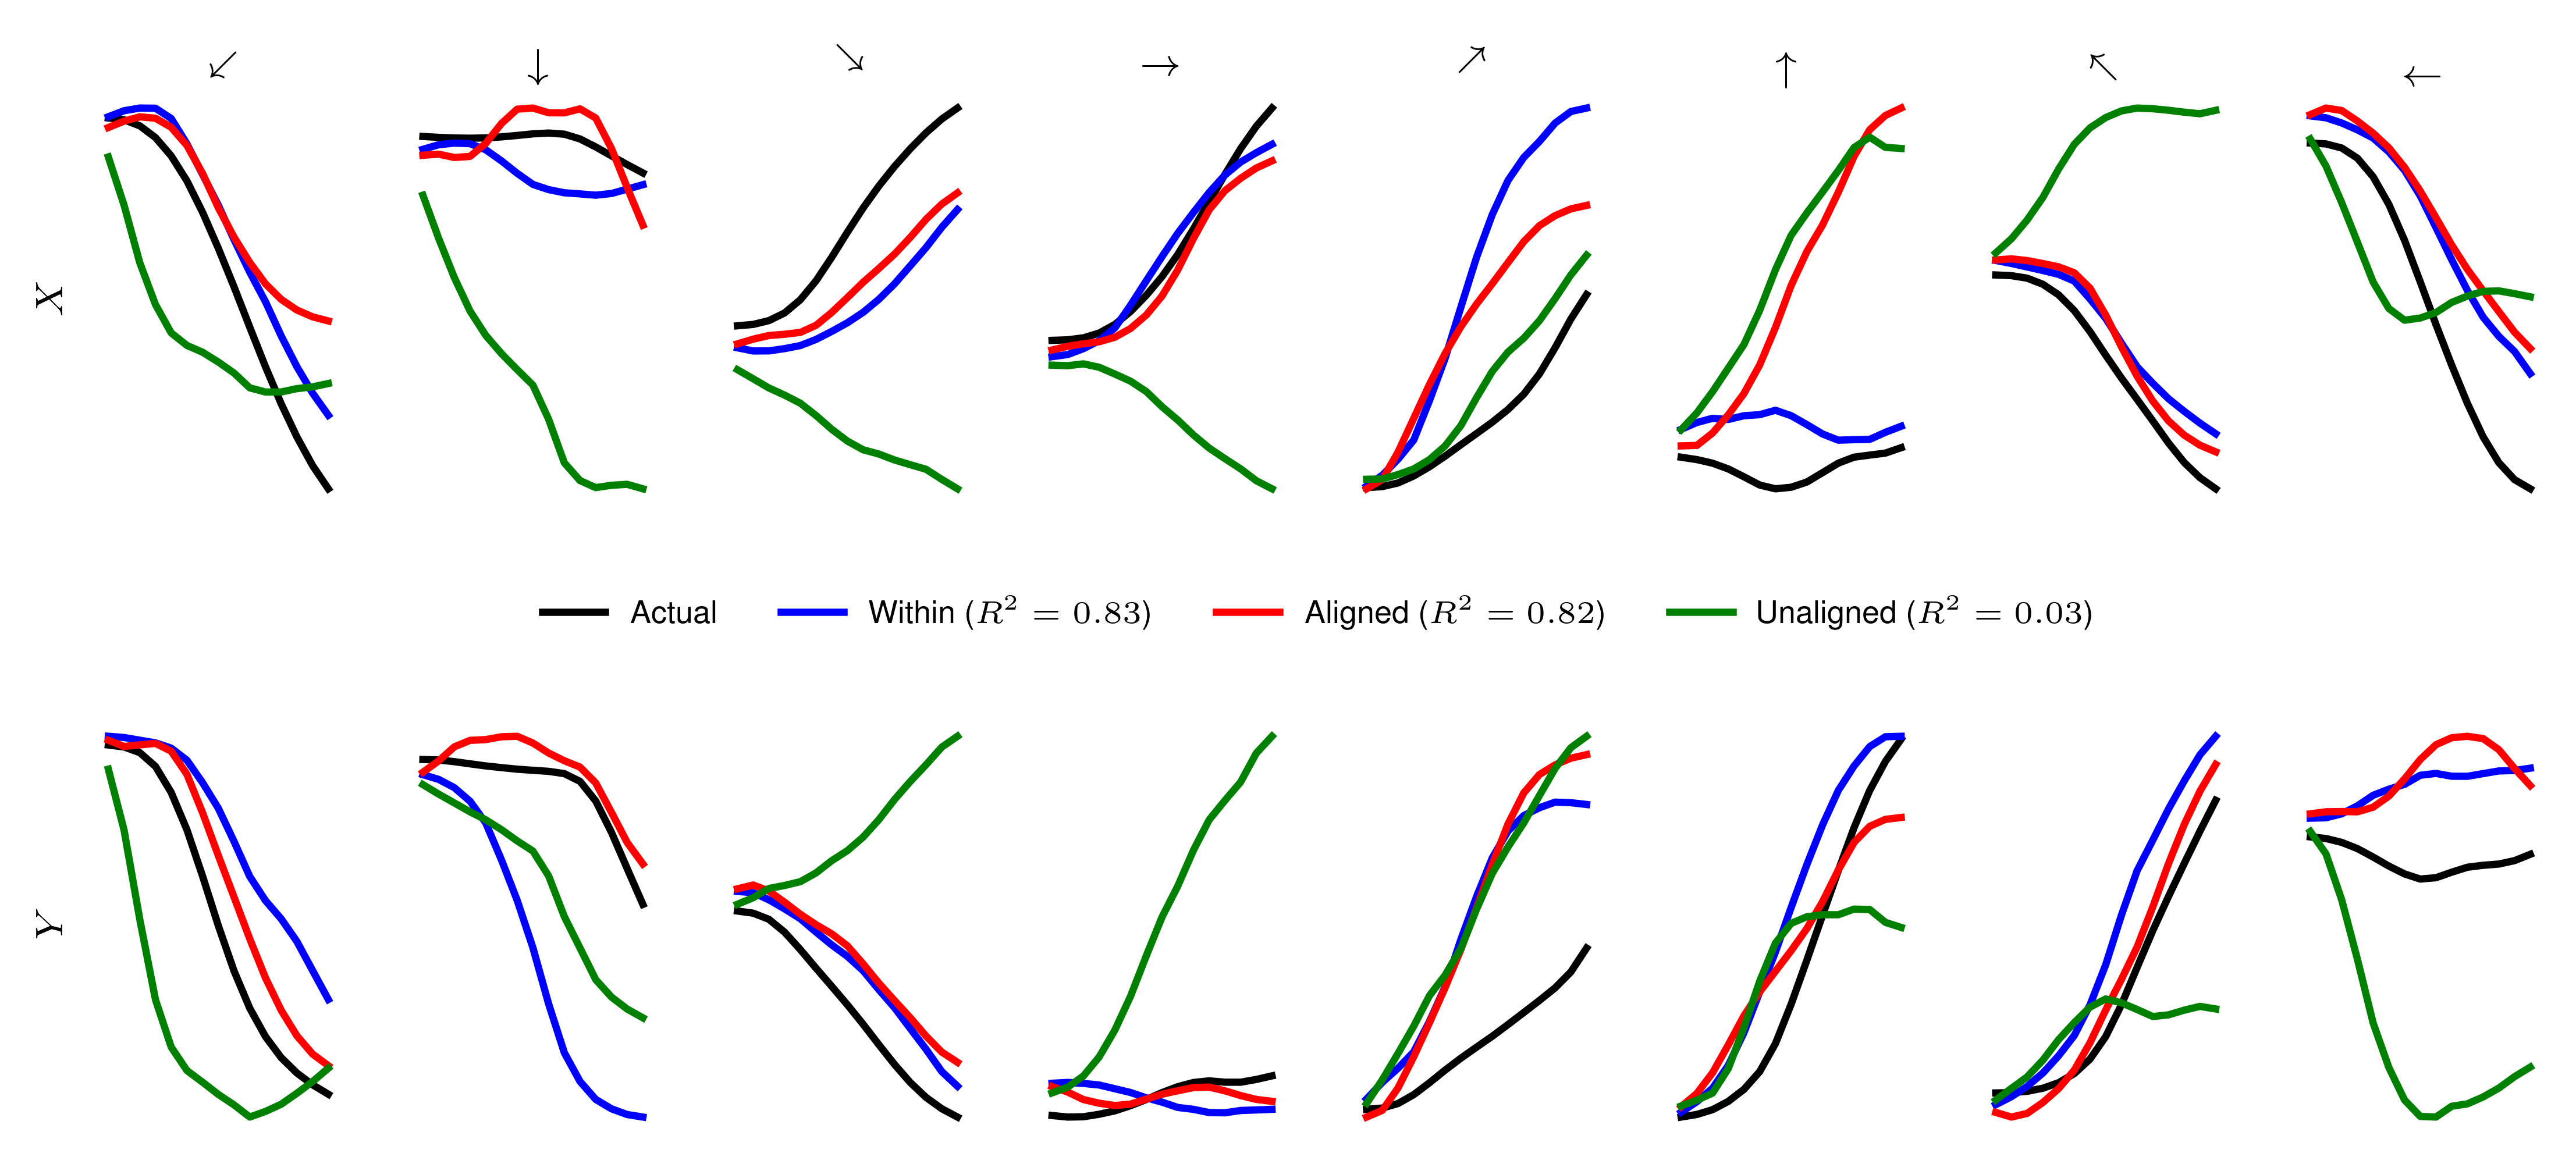

In [2]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    figsize= (params.LargeFig[0],params.panels.BigH)
    fig=plt.figure(figsize=figsize)
    
   
    
    ##########################################
    # 1: Decoding 
    gs1   =fig.add_gridspec(nrows=2, ncols=defs.n_targets,
                           left=0,  # .7" offset
                           right=1,
                           bottom=0,
                           top=1,
                           wspace=0.3, hspace = .5)

       
    axes1 = plot_decoding_ex(fig, gs1, trial_n = 9)
    axes1[0,0].set_ylabel('$X$')
    axes1[1,0].set_ylabel('$Y$')
    
    
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#     AXES=(ax1,ax2,ax3,ax4,ax5,ax6)
#     OFFX=np.array([.02]*len(AXES))
#     OFFY=np.array([.03]*len(AXES))
#     # OFFX[[-1]]=0.12
#     # OFFX[[1]]=0.06
    
#     params.add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)

    fig.savefig(params.figPath / 'figureS4-decode-example.pdf', format='pdf', bbox_inches='tight')